In [1]:
# Get FTIR spectra from files
import sys
sys.path.append("..")
from toolkit.ascfile import read_asc
from glob import glob

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import basename
from tqdm import tqdm
perkin_files = glob("../raw_data/DataHenry23/Perkin/**/*.asc", recursive=True)
perkin_files.extend(glob("../raw_data/DataHenry23/Perkin/**/*.ASC", recursive=True))
ftir_files = glob("../raw_data/DataHenry23/FTIR/**/*.asc", recursive=True)
ftir_files.extend(glob("../raw_data/DataHenry23/FTIR/**/*.ASC", recursive=True))
print(f"Perkin files: {len(perkin_files)}")
print(f"FTIR files: {len(ftir_files)}")
data = []
for i,f in enumerate(tqdm(perkin_files)):
    match = False
    for j, f2 in enumerate(ftir_files):
        b1 = basename(f.replace(".Sample.Raw", "").replace(".asc", ".ASC"))
        perkin_data = read_asc(f)
        b2 = basename(f2.replace("_1", "").replace(".asc", ".ASC"))
        if b1 == b2:
            ftir_data = read_asc(f2)
            data.append((perkin_data[1], ftir_data[1], b1))
            break
print(f"Data size: {len(data)}")

Perkin files: 440
FTIR files: 474


100%|██████████| 440/440 [00:23<00:00, 18.73it/s]

Data size: 0


In [3]:
dshape = len(data), data[0][0].shape[-1]+ data[0][1][::1].shape[-1]
species = { "C": 0, "S": 1, "G": 2}
type = { "C": 0, "F": 1}
location = { "H10": 0, "N10": 1}
X = np.zeros(dshape)
Y = np.zeros((dshape[0], 5), dtype=np.uint32)
for i, (perkin, ftir, fname) in enumerate(data):
    X[i, :] = np.hstack((perkin, ftir[::1]))
    Y[i, 0] = species[fname[1]]      # Espèce
    Y[i, 1] = int(fname[0])          # Process step
    Y[i, 2] = location[fname[3:6]]   # Location
    Y[i, 3] = type[fname[7:8]]       # Grain / Flesh
    Y[i, 4] = int(fname[8:11])       # ID
    if fname[3:6] not in location.keys():
        print("ERROR")
    if fname[7:8] not in type.keys():
        print("ERROR")
    if fname[1] not in species.keys():
        print("ERROR")
        


IndexError: list index out of range

In [12]:
ftir_max = np.max(X[:, 226:], axis=1)
X[:, 226:] /= ftir_max.reshape(ftir_max.shape[0], 1)
perkin_max = np.max(X[:, :226])
X[:, :226] /= perkin_max

In [13]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(in_features, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, out_features)

    def forward(self, X, return_antelatent=False):
        X = torch.tanh(self.l1(X))
        X1 = torch.relu(self.l2(X))
        X = torch.tanh(self.l3(X1))
        if not return_antelatent:
            return X
        else:
            return X, X1

class Decoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(in_features, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, out_features)

    def forward(self, X):
        X = torch.tanh(self.l1(X))
        X = torch.relu(self.l2(X))
        X = torch.tanh(self.l3(X))
        return X

class AutoEncoder(nn.Module):
    def __init__(self, features, latent_features=2, variationnal=False, smoothing=15):
        super(AutoEncoder, self).__init__()
        if variationnal:
            self.enc = Encoder(features, latent_features*2)
            self.dec = Decoder(latent_features, features+smoothing-1)
        else:
            self.enc = Encoder(features, latent_features)
            self.dec = Decoder(latent_features, features+smoothing-1)

        self.latent_features = latent_features
        self.variationnal = variationnal
        self.smoothing = smoothing
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=self.smoothing)
        self.classification = nn.Linear(64, 3)
    def forward(self, X, return_classif=False):
        bs = X.shape[0]
        if self.variationnal:
            if return_classif:
                X, X1 = self.enc(X, return_antelatent=True)
                X = X.view(-1, 2, self.latent_features)
                classif = torch.log_softmax(self.classification(X1), dim=1)
            else:
                X = self.enc(X).view(-1, 2, self.latent_features)
            mu = X[:, 0, :]
            logvar = (X[:, 1, :] - 1) * 5
            X = self.reparameterize(mu, logvar)
            if return_classif:
                return self.c1(self.dec(X).view(bs, 1, -1)).view(bs, -1), mu, logvar, classif
            else:
                return self.c1(self.dec(X).view(bs, 1, -1)).view(bs, -1), mu, logvar
        else:
            return self.c1(self.dec(self.enc(X)).view(bs, 1, -1)).view(bs, -1)
    
    def reconstruct(self, X):
        bs = X.shape[0]
        recons = self.dec(X).view(bs, 1, -1)
        recons = self.c1(recons)
        return (recons.view(bs, -1))
    
    def encode(self, X, std=False):
        code = self.enc(X)
        if self.variationnal:
            view = code.view(-1, 2, self.latent_features)
            if std:
                return view[:, 0, :], view[:, 1, :]
            else:
                return view[:, 0, :]
        else:
            return self.enc(X)

    def reparameterize(self, latent_mean, latent_logvar):
        std = torch.exp(0.5*latent_logvar)
        eps = torch.randn_like(std)
        sample = latent_mean + (eps * std)
        return sample

In [14]:
from sklearn.preprocessing import StandardScaler
#from toolkit.preprocessing import MeanMinMaxScaler
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
#Xs = X.copy()

from torch.utils.data import TensorDataset, DataLoader
loader = DataLoader(TensorDataset(torch.from_numpy(Xs).type(torch.float), torch.from_numpy(Y[:,0].astype(np.int32)).type(torch.long)), batch_size=8, shuffle=True)

0.06275081889409768: 100%|██████████| 1000/1000 [03:32<00:00,  4.70it/s]


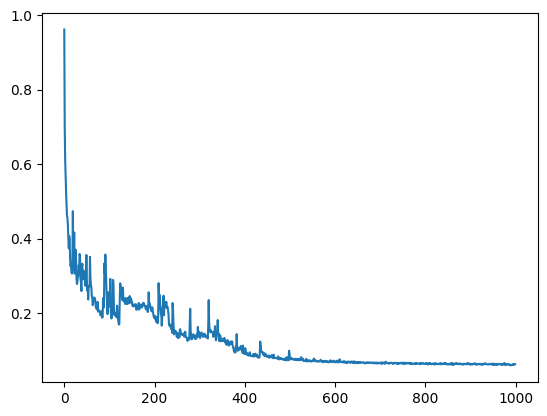

In [38]:
mse_loss = nn.MSELoss()
from torch.optim.lr_scheduler import StepLR
ae = AutoEncoder(Xs.shape[1], 2, variationnal=True, smoothing=15)
from torch.optim import Adam
optim = Adam(ae.parameters(), lr=1e-3, weight_decay=1e-4)
num_epochs = 1000
from tqdm import trange
losses = list()
nll_loss = nn.NLLLoss()
scheduler = StepLR(optim, step_size=10, gamma=0.95)

progress_bar = trange(num_epochs)
for epoch in progress_bar:
    epoch_loss = 0.0
    for X_real, Y_real in loader:
        bs = X_real.shape[0]
        optim.zero_grad()
        X_a = X_real.clone()
        X_a[:, 165:] *= 0.9 + np.random.rand(bs, 1) * 0.1
        X_a[:, :] *= 0.7 + 0.3 * np.random.rand(bs, 1)
        X_a[:,:] += torch.randn(bs, X_a.shape[1]) * 0.1
        Xp, mu, logvar, classif = ae(X_a, return_classif=True)
        recons_loss = mse_loss(Xp, X_real)
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        (recons_loss+kld_loss*1e-3+nll_loss(classif, Y_real)).backward()
        optim.step()

        epoch_loss += recons_loss.item()
    scheduler.step()
    epoch_loss /= len(loader)
    losses.append(epoch_loss)
    progress_bar.set_description_str(f"{epoch_loss}")
plt.plot(losses)

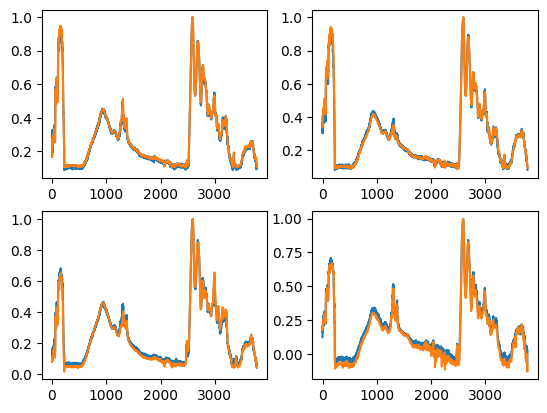

In [39]:
fig, axs = plt.subplots(2,2)
axs= axs.flatten()
for i, ax in enumerate(axs):
    ax.plot(scaler.inverse_transform(X_a.detach().numpy())[i, :])
    ax.plot(scaler.inverse_transform(Xp.detach().numpy())[i, :])

v = 3
X = 13
^ = 103
x = 113


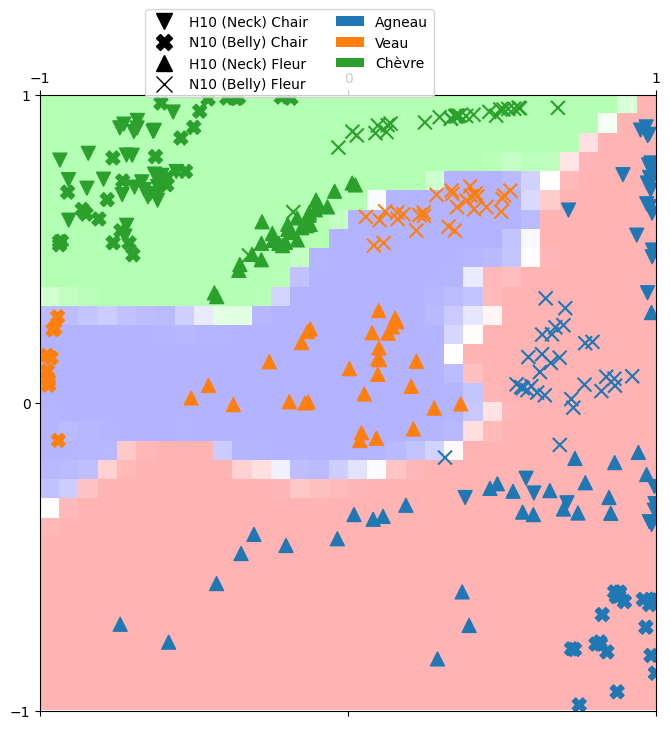

In [40]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
my_cmapr = ListedColormap([(1.0, 0.0,0.0, i/255) for i in range(255)])
my_cmapg = ListedColormap([(0.0, 1.0,0.0, i/255) for i in range(255)])
my_cmapb = ListedColormap([(0.0, 0.0,1.0, i/255) for i in range(255)])

latent = ae.encode(torch.from_numpy(Xs).type(torch.float)).detach().numpy()
if True:
    x = np.linspace(-1, 1, 32)
    XX, YY = np.meshgrid(x,x)
    XY = np.vstack((XX.flat, YY.flat)).T
    spectres = ae.reconstruct(torch.from_numpy(XY).type(torch.float))
    _, _, _, classif = ae(spectres, return_classif=True)
    classif = classif.detach().numpy()

markers = ["v", "X", "^", "x"]
fig, ax = plt.subplots(figsize=(8,8))
if True:         
    ax.matshow(np.exp(classif.reshape(32,32, 3)[:,:,0]), origin="lower", extent=[-1,1,-1,1], cmap=my_cmapr, vmin=0.5, vmax=1.0, alpha=0.3)  
    ax.matshow(np.exp(classif.reshape(32,32, 3)[:,:,1]), origin="lower", extent=[-1,1,-1,1], cmap=my_cmapb, vmin=0.5, vmax=1.0, alpha=0.3)  
    ax.matshow(np.exp(classif.reshape(32,32, 3)[:,:,2]), origin="lower", extent=[-1,1,-1,1], cmap=my_cmapg, vmin=0.5, vmax=1.0, alpha=0.3)  
markerlabel = np.array([ a  + b * 10 + c*100 for a, b, c in zip( Y[:, 1], Y[:, 2], Y[:, 3])]) # Process, Location, Side
for i, c in enumerate(np.unique(markerlabel)):
    print(markers[i], "=", c)
    mask = markerlabel == c
    cur = latent[mask,:]
    ax.scatter(*cur.T, c=[f"C{l}" for l in Y[mask, 0].flat], marker=markers[i], s=100)
legend_elements = [Line2D([0], [0], marker="v", markersize=12, color='k', linestyle="", label='H10 (Neck) Chair'),
                   Line2D([0], [0], marker="X", markersize=12, color='k', linestyle="", label='N10 (Belly) Chair'),
                   Line2D([0], [0], marker='^', color='k', linestyle="", label='H10 (Neck) Fleur', markersize=12),
                   Line2D([0], [0], marker='x', color='k', linestyle="", label='N10 (Belly) Fleur', markersize=12),
                   Patch(facecolor='C0',  label='Agneau'),
                   Patch(facecolor='C1',  label='Veau'),
                   Patch(facecolor='C2',  label='Chèvre'),
                   ]

plt.axis("square")
plt.axis([-1, 1, -1, 1])
plt.legend(handles=legend_elements, bbox_to_anchor =(0.65, 1.15), ncol=2)

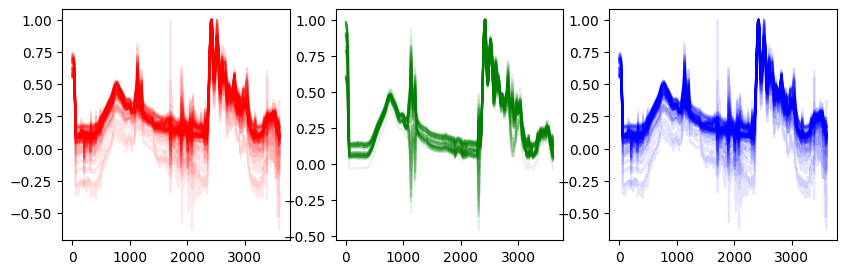

In [44]:
calfs = X[Y[:, 0]==0]
sheeps = X[Y[:, 0]==1]
fig, axs = plt.subplots(1,3, figsize=(10,3))
axs[0].plot(calfs.T[168:], 'r-', alpha=0.1)
axs[1].plot(sheeps.T[168:], 'g-', alpha=0.1)
axs[2].plot(calfs.T[168:], 'b-', alpha=0.1)

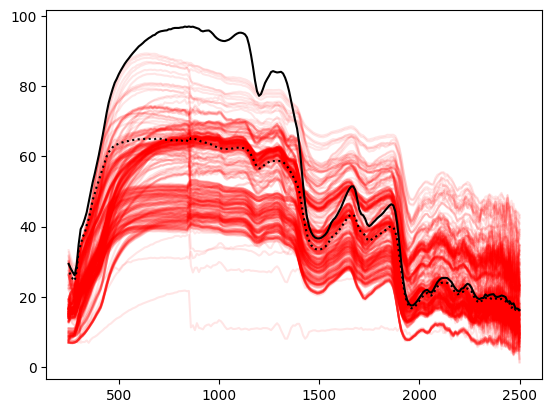

In [84]:
for i, file in enumerate(perkin_files):
    plt.plot(*read_asc(file), alpha=0.1, color="red")
plt.plot(*data, color="k")
plt.plot(*data1, color="k", ls=":")
#plt.axvline(860)
#plt.axvline(729)

    

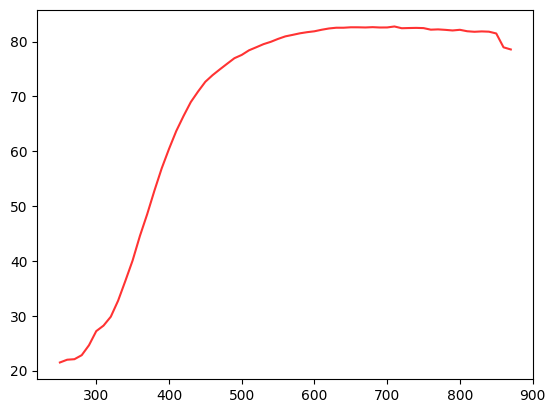

In [106]:
#for i, file in enumerate(perkin_files[4:6]):
#    plt.plot(*read_asc(file), alpha=0.8, color="red")

x, p1 = read_asc(perkin_files[4])
x, p2 = read_asc(perkin_files[5])
mm = 163
plt.plot(x[mm:], p1[mm:]+2, alpha=0.8, color="red")
#plt.plot(x, p2, alpha=0.8, color="black")

#plt.axvline(860)
#plt.axvline(729)



In [82]:
perkin_files[4:6]

['../raw_data/DataHenry23/Perkin/Ancien_Parcht_Perkin/S-11771-005.Sample.Raw.asc',
 '../raw_data/DataHenry23/Perkin/Ancien_Parcht_Perkin/S-11771-002.Sample.Raw.asc']

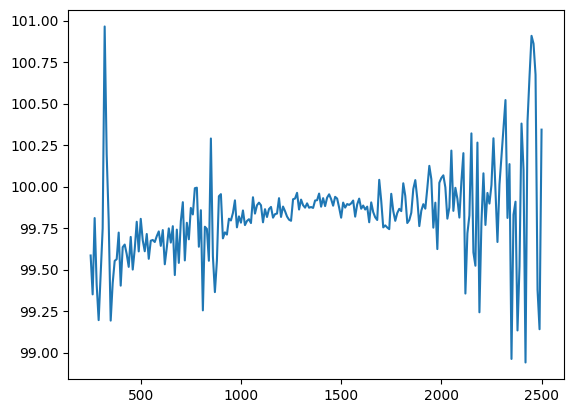

In [46]:
data = read_asc("../blanc_20minchauffe.Sample.asc")
plt.plot(*data)

In [87]:
# let's shap !
import shap
import torch
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, ae):
        super(Classifier, self).__init__()
        self.ae = ae
        
    def forward(self, X):
        _,_,_,classif = self.ae(X, return_classif=True)
        return classif

classif_model = Classifier(ae)
batch = torch.from_numpy(Xs).type(torch.float)
idx = torch.randperm(batch.shape[0])
batch[idx, :] = batch.clone()
background = batch[:250]
test_images = batch[250:]

e = shap.DeepExplainer(classif_model, background)
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


(0.0, 1.0)

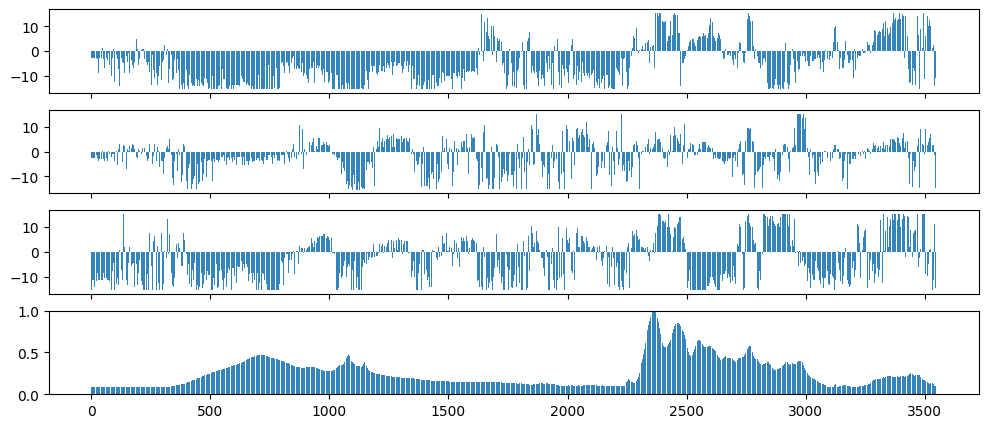

In [90]:
shap_values[0].shape
shap_values = np.asarray(shap_values).copy()
shap_values[shap_values>0] = np.exp(shap_values[shap_values>0])
mask = shap_values<=0
shap_values[mask] = -np.exp(-shap_values[mask])
fig, axs = plt.subplots(4,1, figsize=(12,5), sharex=True, sharey=False)
size_ftir = shap_values[0][:,226:].shape[-1]
x = np.linspace(450, 4000, 3551)
axs[0].bar(np.arange(size_ftir), np.mean((shap_values[0][:,226:]), axis=0), alpha=0.9)
axs[1].bar(np.arange(size_ftir), np.mean((shap_values[1][:,226:]), axis=0), alpha=0.9)
axs[2].bar(np.arange(size_ftir), np.mean((shap_values[2][:,226:]), axis=0), alpha=0.9)
axs[3].bar(np.arange(size_ftir), np.mean(X[Y[:,0]==1][:,226:], axis=0), alpha=0.9)
axs[3].set_ylim(0, 1)
#axs[2].set_ylim(-0.001, 0.001)
#axs[1].plot(np.mean((shap_values[0][:,:226]), axis=0))
#axs[1].plot(np.mean((shap_values[1][:,:226]), axis=0))
#axs[1].plot(np.mean((shap_values[2][:,:226]), axis=0))

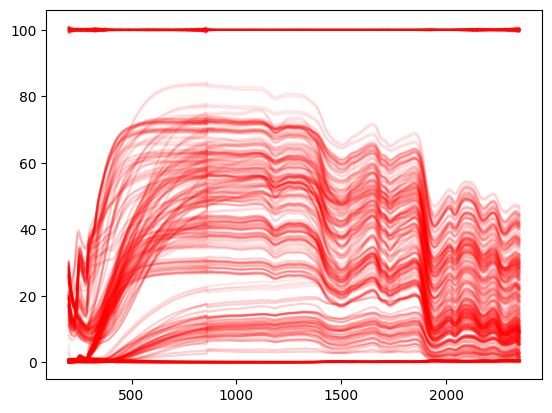

In [16]:
perkin_files = glob("../raw_data/200to2350nm--Data/**/*.asc", recursive=True)
for f in perkin_files:
    plt.plot(*read_asc(f), color="r", alpha=0.1)

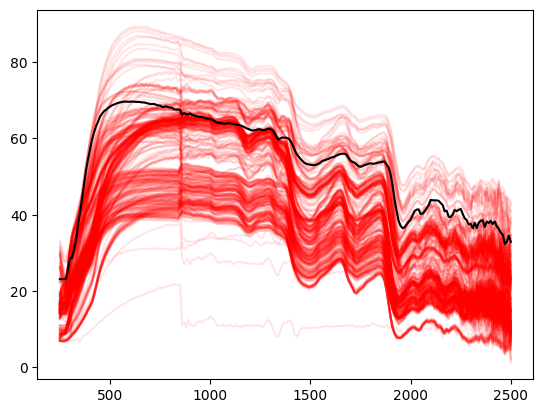

In [94]:
old = "/Users/kaeryv/prj/parchments2/raw_data/DataHenry23/Perkin/Ancien_Parcht_Perkin/S-11753-001.Sample.Raw.asc"
old = read_asc(old)
for f in perkin_files:
    plt.plot(*read_asc(f), color="r", alpha=0.1)
plt.plot(*old, c="k")